<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/examplespline_computationgraphworking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

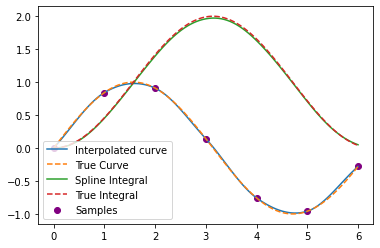

In [1]:
import matplotlib.pylab as P
import torch as T

def h_poly_helper(tt):
  A = T.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def H_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = t
  for i in range(1, 4):
    tt[i] = tt[i-1]*t*i/(i+1)
  return h_poly_helper(tt)

def interp(x, y, xs):
  m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
  m = T.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  I = P.searchsorted(x[1:], xs)
  dx = (x[I+1]-x[I])
  hh = h_poly((xs-x[I])/dx)
  return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx

def integ(x, y, xs):
  m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
  m = T.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  I = P.searchsorted(x[1:], xs)
  Y = T.zeros_like(y)
  Y[1:] = (x[1:]-x[:-1])*(
      (y[:-1]+y[1:])/2 + (m[:-1] - m[1:])*(x[1:]-x[:-1])/12
      )
  Y = Y.cumsum(0)
  dx = (x[I+1]-x[I])
  hh = H_poly((xs-x[I])/dx)
  return Y[I] + dx*(
      hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
      )

# Example
if __name__ == "__main__":
  x = T.linspace(0, 6, 7)
  y = x.sin()
  xs = T.linspace(0, 6, 101)
  ys = interp(x, y, xs)
  Ys = integ(x, y, xs)
  P.scatter(x, y, label='Samples', color='purple')
  P.plot(xs, ys, label='Interpolated curve')
  P.plot(xs, xs.sin(), '--', label='True Curve')
  P.plot(xs, Ys, label='Spline Integral')
  P.plot(xs, 1-xs.cos(), '--', label='True Integral')
  P.legend()
  P.show()


In [2]:
x = T.linspace(0,6,7)

In [3]:
y = x.sin()

In [4]:
xs = T.linspace(0, 6, 101)
ys = interp(x, y, xs)


In [5]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self,outclass = 101):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(101, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, outclass),
            nn.Tanh()
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x


In [6]:
#print(xs.shape)
#a = torch.zeros(2,101)
#model(a).shape

In [7]:
model = MLP()
learning_rate = .0001
optimizer = T.optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
for i in range(1000):
  output = model(xs.unsqueeze(0))
  loss = T.mean(T.abs(output-ys))
  print('loss',loss)
  loss.backward()
  optimizer.step()

loss tensor(0.6639, grad_fn=<MeanBackward0>)
loss tensor(0.6603, grad_fn=<MeanBackward0>)
loss tensor(0.6570, grad_fn=<MeanBackward0>)
loss tensor(0.6536, grad_fn=<MeanBackward0>)
loss tensor(0.6503, grad_fn=<MeanBackward0>)
loss tensor(0.6470, grad_fn=<MeanBackward0>)
loss tensor(0.6439, grad_fn=<MeanBackward0>)
loss tensor(0.6408, grad_fn=<MeanBackward0>)
loss tensor(0.6377, grad_fn=<MeanBackward0>)
loss tensor(0.6347, grad_fn=<MeanBackward0>)
loss tensor(0.6318, grad_fn=<MeanBackward0>)
loss tensor(0.6291, grad_fn=<MeanBackward0>)
loss tensor(0.6266, grad_fn=<MeanBackward0>)
loss tensor(0.6243, grad_fn=<MeanBackward0>)
loss tensor(0.6221, grad_fn=<MeanBackward0>)
loss tensor(0.6198, grad_fn=<MeanBackward0>)
loss tensor(0.6174, grad_fn=<MeanBackward0>)
loss tensor(0.6151, grad_fn=<MeanBackward0>)
loss tensor(0.6126, grad_fn=<MeanBackward0>)
loss tensor(0.6101, grad_fn=<MeanBackward0>)
loss tensor(0.6077, grad_fn=<MeanBackward0>)
loss tensor(0.6054, grad_fn=<MeanBackward0>)
loss tenso

torch.Size([101])


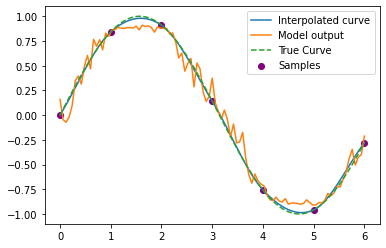

In [9]:
x = T.linspace(0, 6, 7)
y = x.sin()
xs = T.linspace(0, 6, 101)
out = model(xs.unsqueeze(0)).squeeze().detach()
print(xs.shape)
ys = interp(x, y, xs)
Ys = integ(x, y, xs)
P.scatter(x, y, label='Samples', color='purple')
P.plot(xs, ys, label='Interpolated curve')
P.plot(xs, out.numpy(), label='Model output')
P.plot(xs, xs.sin(), '--', label='True Curve')
P.legend()
P.show()


In [13]:
oc = 25
model = MLP(outclass=oc)
optimizer = T.optim.Adam(model.parameters(), lr=learning_rate)
x = T.linspace(0, 30, 25)
y = x.sin()
modelin = T.linspace(0, 30, 101)
xs = T.linspace(0, 30, 25)
xoc = T.linspace(0, 30, oc)

ys = interp(x, y, xs)
print(xoc.shape)

torch.Size([25])


In [14]:
for i in range(1000):
  output = model(modelin.unsqueeze(0)).squeeze()
  print(output.shape)
  yout = interp(xoc,output,xs)
  loss = T.mean((yout-ys)**2)
  print('loss',loss)
  loss.backward()
  optimizer.step()

torch.Size([25])
loss tensor(0.7477, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.7036, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.6642, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.6268, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.5882, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.5510, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.5144, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.4781, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.4437, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.4115, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.3800, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.3489, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.3200, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.2943, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.2715, grad_fn=<MeanBackward0>)
torch.Size([25])
loss tensor(0.2511, grad_fn=<MeanBackward0>)
torch.Si

torch.Size([101])


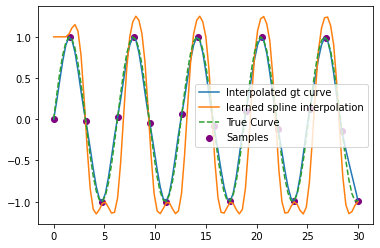

In [17]:
x = T.linspace(0, 30, 20)
y = x.sin()
xs = T.linspace(0, 30, 101)
out = model(xs.unsqueeze(0)).squeeze()
out = interp(xoc,output,xs).detach()
print(xs.shape)
ys = interp(x, y, xs)
Ys = integ(x, y, xs)
P.scatter(x, y, label='Samples', color='purple')
P.plot(xs, ys, label='Interpolated gt curve')
P.plot(xs, out.numpy(), label='learned spline interpolation')
P.plot(xs, xs.sin(), '--', label='True Curve')
P.legend()
P.show()


In [83]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self,outclass = 101):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, outclass),
            nn.Tanh()
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = self.layers(x)
        x=x*5.0
        return x


In [90]:
oc = 20
model = MLP(outclass=oc)
optimizer = T.optim.Adam(model.parameters(), lr=.00001)
x = T.linspace(0, 30, 25)
xs = T.linspace(0, 30, 100)
xoc = T.linspace(0, 30, oc)
print(xoc.shape)

torch.Size([20])


In [91]:
for i in range(1000):
  c = [T.linspace(0, 30, 100) for x in range(16)]
  xin = T.cat(c).reshape(16,-1)
  yin = [ x.sin()*(.5+T.rand(1)) + 2.0*T.rand(1) for x in c]
  yin = T.cat(yin).reshape(16,-1)
  modelin = T.cat([xin, yin],dim=1)
  output = model(modelin).squeeze()
  print(xoc.shape, output.shape, xs.shape )
  inte = [interp(xoc,output[i,:],xs) for i in range(16)]
  inte = T.cat(inte)
  inte = inte.reshape(16,-1)
  #yout = interp(xoc,output,xs)
  yout = inte
  loss = T.mean((yout-yin.detach())**2)
  print('loss',loss)
  loss.backward()
  optimizer.step()

torch.Size([20]) torch.Size([16, 20]) torch.Size([100])
loss tensor(5.7526, grad_fn=<MeanBackward0>)
torch.Size([20]) torch.Size([16, 20]) torch.Size([100])
loss tensor(4.5478, grad_fn=<MeanBackward0>)
torch.Size([20]) torch.Size([16, 20]) torch.Size([100])
loss tensor(4.9592, grad_fn=<MeanBackward0>)
torch.Size([20]) torch.Size([16, 20]) torch.Size([100])
loss tensor(5.1945, grad_fn=<MeanBackward0>)
torch.Size([20]) torch.Size([16, 20]) torch.Size([100])
loss tensor(4.5423, grad_fn=<MeanBackward0>)
torch.Size([20]) torch.Size([16, 20]) torch.Size([100])
loss tensor(4.8877, grad_fn=<MeanBackward0>)
torch.Size([20]) torch.Size([16, 20]) torch.Size([100])
loss tensor(4.4194, grad_fn=<MeanBackward0>)
torch.Size([20]) torch.Size([16, 20]) torch.Size([100])
loss tensor(4.5155, grad_fn=<MeanBackward0>)
torch.Size([20]) torch.Size([16, 20]) torch.Size([100])
loss tensor(4.7217, grad_fn=<MeanBackward0>)
torch.Size([20]) torch.Size([16, 20]) torch.Size([100])
loss tensor(4.4138, grad_fn=<MeanBa

In [92]:
"""x = T.tensor([a for a in range(25)])
x = x.float()
x = T.cat([x,x])
x = x.reshape(2,-1)
y = T.tensor([a for a in range(25)])
y = y.float()
y = T.cat([y,y])
y = y.reshape(2,-1)
t = T.tensor([a for a in range(25)])
t = t.float()
t = T.cat([t,t])
t = t.reshape(2,-1)

print(x.shape,y.shape,t.shape)
#interp(x,y,t)
"""


'x = T.tensor([a for a in range(25)])\nx = x.float()\nx = T.cat([x,x])\nx = x.reshape(2,-1)\ny = T.tensor([a for a in range(25)])\ny = y.float()\ny = T.cat([y,y])\ny = y.reshape(2,-1)\nt = T.tensor([a for a in range(25)])\nt = t.float()\nt = T.cat([t,t])\nt = t.reshape(2,-1)\n\nprint(x.shape,y.shape,t.shape)\n#interp(x,y,t)\n'

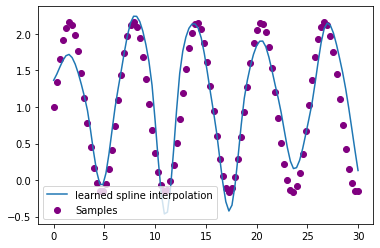

In [93]:
x = T.linspace(0, 30, 100)
modelin = T.linspace(0, 30, 100)
a = T.rand(1)
b = T.rand(1)
ys = modelin.sin()*(.5+a) + 2.0*b
modelin = T.cat([modelin, ys])
output = model(modelin.unsqueeze(0)).squeeze()
yout = interp(xoc,output,xs)
yout = yout.detach()
  
P.scatter(x, ys, label='Samples', color='purple')
P.plot(xs, yout.numpy(), label='learned spline interpolation')
P.legend()
P.show()